# NITRIFICATION MODEL

Author: Emiel Kruisdijk,  Date: 12-08-2022

Based on data from de Kreuk 2007 BB Kinetic model of a granular sludge SBR: Influences on nutrient removal

https://onlinelibrary.wiley.com/doi/abs/10.1002/bit.21196

## Introduction

Welcome to this easy-to-use nitrification model! In this model, we try to guide you through the model step by step, and, afterwards, you will use the model to simulate nitrification and answer the questions asked.


In [1]:
#First, we will open all packages that are needed for the model and data analysis
#A python package is a directory with prefab python modules, which can be used in your script.

#The pandas package is made for data analysis, and can be somewhat compared with microsoft excel
import pandas as pd

#Numpy is the package for scientific computing with python.

#! IMPORT THE NUMPY PACKAGE HERE AS NP

#The SciPy package provides algorithms for optimization, integration, interpolation etc. Here we import specifically the
#modules related to integration
from scipy.integrate import odeint

#The pyplot package is often used for visualization of results.

#! IMPORT PYPLOT AS PLT FROM MATPLOTLIB

## Nitrification reaction equations

Nitrification is a two-step biological process, in which $NH_{4}$ is transformed to $NO_{3}$ with $NO_{2}$ as an intermittend product. See reaction equations below:

Step 1: $$ NH_{4}^{+} + 1.5O_{2}  \Rightarrow  NO_{2}^{-} + H_{2}O + 2H^{+} $$

Step 2: $$ NO_{2}^{-} + 0.5O_{2} \Rightarrow NO_{3}^{-} $$

Both reactions are extensively researched, and rate equations are known and often used.


## Rate equation nitrification (step 1)

Nitrification (Step 1):

The equation below can be used to calculate the  process rate of the first step of nitrification. It is a Monod-type rate equation, which is often used to present biological conversion processes. The equation is a differential equation, which can be used to calculate the rate of the biological conversion (thus: change of concentration over a period of time, dS/dT)

$$ Process \ rate = \mu _{max}^{AOB} x \frac{S_{O_{2}}}{K_{O_{2}}^{AOB}+S_{O_{2}}} x \frac{S_{NH}}{K_{NH}^{AOB}+S_{NH}} x X_{AOB}$$

where $\mu _{max}$ is the maximum growth rate of ammonium oxidizing bacteria (AOB), $S_{i}$ the concentration of solute i, $K_{i}$ the half-saturation coefficient of i, and $X_{AOB}$ is the COD concentration.

The values of the parameters in the rate equation are defined below.

## Rate equation nitrification (step 2)

Nitrification (Step 2):

A similar type of equation can be used to calculate the process rate of the second step of nitrification.

Rate equation:

$$ Process \ rate = \mu _{max}^{NOB} x \frac{S_{O_{2}}}{K_{O_{2}}^{NOB}+S_{O_{2}}} x \frac{S_{NO_{2}}}{K_{NO_{2}}^{NOB}+S_{NO_{2}}} x X_{NOB}$$

where $\mu _{max}$ is the maximum growth rate of nitrite oxidizing bacteria (AOB), and $X_{NOB}$ is the COD concentration.

The values of the parameters in the rate equation are defined below.

## Parameters used in simulation

Maximum specific growth rate (Xnh)  µ$_{NH}$ = 0.4 d$^{-1}$ --> In model unh

Maximum specific growth rate (Xno)  µ$_{NO}$ = 1.1 d$^{-1}$ --> In model uno

Nitrogen content of biomass  i$_{nbm}$ = 0.07 gN x gCOD$^{-1}$ --> In model inbm

Yield for growth of ammonium oxidizers  Y$_{NH}$ = 0.15 gCOD x gN$^{-1}$ --> In model Ynh

Yield for growth of nitrite oxidizers  Y$_{NO}$ = 0.041 gCOD x gN$^{-1}$ --> In model Yno

Half-saturation coefficient for oxygen (Xnh)  K$_{O2,NH}$ = 0.3 --> In model KO2nh

Half-saturation coefficient for ammonium (Xnh)  K$_{NH4,NH}$ = 2.4 --> In model Knh

Half-saturation coefficient for oxygen (Xno)  K$_{O2,NO}$ = 0.1 --> In model KO2no

Half-saturation coefficient for nitrite (Xno)  K$_{NO2,NO}$ = 0.238 --> In model KNO2no

In [2]:
#Parameters used in simulation

unh=0.4 #maximum specific growth rate (Xnh)

#! FILL IN THE OTHER PARAMETERS BELOW, BASED ON THE DATA PROVIDED IN THE TEXT ABOVE

uno= #Maximum specific growth rate (Xno)

inbm= #Nitrogen content of biomass (gN x gCOD-1)

Ynh= #Yield for growth of ammonium oxidizers
Yno= #Yield for growth of nitrite oxidizers


KO2nh= #Half-saturation coefficient for oxygen (Xnh)
Knh= #Half-saturation coefficient for ammonium (Xnh)
KO2no= #Half-saturation coefficient for oxygen (Xno)
KNO2no= #Half-saturation coefficient for nitrite (Xno)

## Stoichiometric Matrix

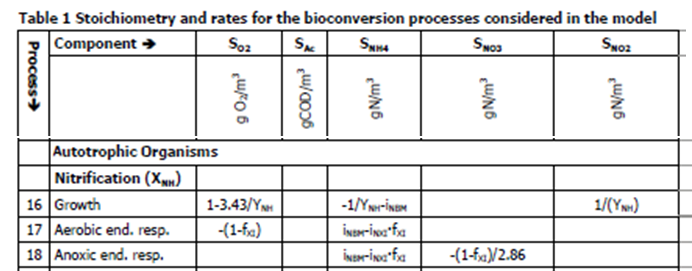

The figure above shows the stoichiometric matrix. This matrix shows the rates for the specific bioconversion processes. 

How to use this matrix?

First, we need to calculate a process rate with the Monod-type rate equations shown above. Second, we need to multiply the rate observed in the stoichiometrix matrix with the process rate to obtain the change in concentration for this specific parameter.

Let's,for example, calculate the change in oxygen concentration (S$_{O_{2}}$) during the first step of nitrification. This can be done by multiplying the process rate by the rate for the bioconversion of O$_{2}$. Combining both formulas you will end up with the following equation:

$$ Process \ rate \ O_{2} = (1-\frac{3.43}{Y_{NH}}) x \mu _{max}^{AOB} x \frac{S_{O_{2}}}{K_{O_{2}}^{AOB}+S_{O_{2}}} x \frac{S_{NH}}{K_{NH}^{AOB}+S_{NH}} x X_{AOB}$$

The last step is to plot the O$_2$ concentrations over time. And, therefore, we need to solve the differential equation. In the model below, we do this by dividing the period that we want to research in small timesteps. The model goes through all the timesteps one by one, and calculates for every timestep the process rate and multiplies this with the timestep. This gives the change in concentration during this timestep. Lastly, the change in concentration is added to the concentration calculated in the timestep before. A start concentration should be given to do this calculation for the first timestep.

These steps above should be repeated for the other solutes and biomass involved in nitrification.

## Simulating nitrification over time

Below we simulate nitrification using a differential equation solver:

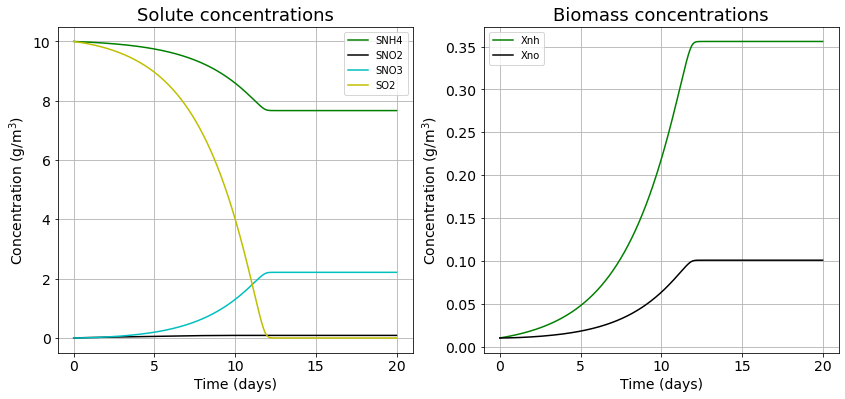

In [3]:
#differential equations
def odes(x,t):
    #First step nitrification
    # assign each ODE to a vector element
    Xnh = x[0]
    SNH4 = x[1]
    SO2 = x[2]
    SNO2 = x[3]
    SNO3 = x[4]
    Xno = x[5]
    
    #define each ODE
    dXnhdt = 1*unh*(SO2/(KO2nh+SO2))*(SNH4/(Knh+SNH4))*Xnh
    dSnhdt = (-1/Ynh-inbm)*unh*(SO2/(KO2nh+SO2))*(SNH4/(Knh+SNH4))*Xnh
    dSO2dt = (1-(3.43/Ynh))* unh*(SO2/(KO2nh+SO2))*(SNH4/(Knh+SNH4))*Xnh+(1-(1.14/Yno))*uno*(SNO2/(KNO2no+SNO2))*(SO2/(KO2nh+SO2))*Xno
    dSNO2dt = (1/Ynh)* unh*(SO2/(KO2nh+SO2))*(SNH4/(Knh+SNH4))*Xnh+(-1/Yno-inbm)*uno*(SNO2/(KNO2no+SNO2))*(SO2/(KO2nh+SO2))*Xno
    dSNO3dt = (1/Yno)* uno*(SNO2/(KNO2no+SNO2))*(SO2/(KO2nh+SO2))*Xno
    dXnodt = 1*uno*(SNO2/(KNO2no+SNO2))*(SO2/(KO2nh+SO2))*Xno
   
    return [dXnhdt, dSnhdt, dSO2dt, dSNO2dt, dSNO3dt, dXnodt]

#initial conditions
x0 = [0.01, 10, 10, 0, 0, 0.01] #Initial condition x[0], x[1], x[2], x[3], x[4], x[5], x[6]

#declare a time vector (time window)

#! VISIT https://numpy.org/doc/stable/reference/generated/numpy.linspace.html AND FILL IN THE EQUATION BELOW
#! t REPRESENTS THE TIME INTERVAL FOR WHICH THE DIFFERENTIAL EQUATIONS ARE SOLVED, WHAT IS AN INSIGHTFUL TIME INTERVAL?
#! AND WHAT A SUFFICIENT TIMESTEP?
t =np.linspace(???)

x= odeint(odes, x0, t)

Xnh = x[:,0]
SNH4 = x[:,1]
SO2 = x[:,2] 
SNO2 = x[:,3] 
SNO3 = x[:,4]
Xno = x[:,5]

#plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6)) #this function plots an empty figure, which will be filled
ax2.plot(t, Xnh, color='g', label='Xnh')
ax2.plot(t, Xno, color='k', label='Xno')
ax1.plot(t, SNH4, color='g', label='SNH4')
ax1.plot(t, SNO2, color='k', label='SNO2')
ax1.plot(t, SNO3, color='c', label='SNO3')
ax1.plot(t, SO2, color='y', label='SO2')

#The lines below are used to create a 'nice' lay-out of the figure
ax1.grid()
ax2.grid()
ax1.set_xlabel('Time (days)', fontsize=14)
ax1.set_ylabel('Concentration (g/m$^{3}$)', fontsize=14)
ax2.set_xlabel('Time (days)', fontsize=14)
ax2.set_ylabel('Concentration (g/m$^{3}$)', fontsize=14)
ax1.set_title('Solute concentrations', fontsize=18)
ax2.set_title('Biomass concentrations', fontsize=18)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax1.legend()
ax2.legend()